### Tabular Q-learning in a mean-reverting environment.

This example is loosely based on the paper "Machine Learning for Trading" by Gordon Ritter, which is available for free online: 

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3015609

This homework assignment has 4 problems. 

1. finish writing the next_price function in TradingEnvironment
2. finish writing the step function in TradingEnvironment
3. finish writing the update function in TabularQLearner
4.  (a) run the train() function and plot the cumulative pnl. 
    (b) print the sharpe ratio. 
    (c) plot the Q-function's optimal action as a function of the price, where price goes from 0 to 100. 
    (d) interpret the results. 

In [1]:
## first, import the libraries we are going to use

import matplotlib.pyplot as plt
import sys
import numpy as np 
import math
import decimal
from random import random
from collections import namedtuple
import time

In [2]:
def index_list(L): 
    """from a list, build a dictionary which list element to position"""
    return dict(zip(L, [x for x in range(0, len(L))]))

# this will map A to 0, B to 1, and C to 2
print(index_list(["A", "B", "C"]))

{'A': 0, 'B': 1, 'C': 2}


In [3]:
def runif(): 
    """uniform random number generator"""
    return np.random.uniform(0, 1, 1)[0]

In [4]:
## now let's set up the tick size, lot size, max position
TickSizeStr = '0.1'
TickSize = float(TickSizeStr)
TickDecimals = abs(decimal.Decimal(TickSizeStr).as_tuple().exponent)

LotSize = 100
M = 10
MAX_HOLDING = 1000
K = 5 ## max number of round lots we can trade in one action

In [5]:
## set up the Ornstein-Uhlenbeck process parameters and learning parameters

H = 5 ## half-life
Lambda = math.log(2) / H
sigma = 0.1
p_e = 50
kappa = 1.0e-4

gamma = 0.999 ## discount factor for continuing task

alpha = 0.001 ## learning rate

epsilon = 0.01 ## probability of random action in epsilon-greedy policy

In [6]:
## create simple classes for actions and states
## states are 'priced positions'

Action = namedtuple('Action', ['shares_traded'])
State = namedtuple('State', ['holding', 'price'])

In [7]:
## explicitly create the action space and the state space as python lists

priceGrid = [round(TickSize * x, 2) for x in range(1, 1001)]

actionSpace = [Action(round(LotSize * x, 2)) for x in range(-K, K + 1)]

stateSpace = [State(n, p) for n in range(-MAX_HOLDING, MAX_HOLDING + 1, LotSize) for p in priceGrid]

print([a.shares_traded for a in actionSpace])

[-500, -400, -300, -200, -100, 0, 100, 200, 300, 400, 500]


In [8]:
actionSpace[-1]

Action(shares_traded=500)

In [9]:
stateSpace[-1]

State(holding=1000, price=100.0)

In [10]:
State(0,0)

State(holding=0, price=0)

In [11]:
MIN_PRICE = min(priceGrid)
MAX_PRICE = max(priceGrid)

def snap_to_grid(price):
    """given an arbitrary price, snap it to the discretization defined above"""
    x = round(price, TickDecimals)
    if x < MIN_PRICE: x = MIN_PRICE
    if x > MAX_PRICE: x = MAX_PRICE
    return x

print(snap_to_grid(math.pi))

3.1


In [12]:
MIN_POS = -MAX_HOLDING
MAX_POS = MAX_HOLDING
def snap_lot(action, holding):
    if holding+action < MIN_POS: action = MIN_POS-holding
    if holding+action > MAX_POS: action = MAX_POS-holding
    return action
     

## Q1. The equation for forward propagation for new price
$$y = log(\frac{p}{p_e})$$

$$y = (1-\lambda)y+\sigma N(0,1)$$

$$p_{new} = p_e e ^y$$




## Q2. PnL Calculation (Part of Step function)
### 2.1 Cost
#### Slippage Cost
$$ C_{slip} = |N_{traded}| \times TickSize $$

#### Impact Cost
$$ C_{impact} = N_{traded}^2 \times \frac{TickSize}{LotSize} $$

### 2.2 Profit
$$ Profit = (P_{next} - P_{curr})\times N_{next} $$

### 2.3 PnL

$$ PnL = Profit - C_{slip} - C_{impact} $$

In [13]:
## let's define a python class for the environment. 
## see comments for Problem 1 and 2. 

class TradingEnvironment:
    def __init__(self, init, curr):
        self.initial = init
        self.current = curr

    def next_price(self, p):
        """compute the next price after p, assuming that log(p/p_e) is an O-U process"""
        ## Problem 1. Write this 
        y = np.log(p/p_e)
        y += -Lambda * y + sigma * np.random.randn()
        # use constraint to make sure actions are discrete and within action space
        pnew = snap_to_grid(p_e * np.exp(y))
        return pnew

    def reset(self):
        self.current = self.initial
        return self.current

    def step(self, a):
        """return a 3-tuple containing the next state and the reward. also include pnl for plotting."""
        # current price and current position
        p = self.current.price
        curpos = self.current.holding
        
        # Problem 2. Calculate pnl (profit and loss) and next state. 
        #            Set self.current equal to the next state. 
        # price calculation for next price
        p_new = self.next_price(p)
        
        # the number of shares to buy (negative for sell) for next action
        """ restrict the shares traded such that we'll not touch the boundaries"""
        shares_traded = snap_lot(a.shares_traded, curpos)
        
        # PnL calculation
        """ slippage cost """
        slip = abs(shares_traded)*TickSize
        """ impact cost """
        impact = shares_traded * shares_traded * TickSize / LotSize
        total_cost = slip + impact
        # price difference 
        price_diff = p_new - p
        # next holding value
        next_holding = curpos + shares_traded
        # final PnL calculation
        pnl = next_holding * price_diff - total_cost
            
        
        # reward calculation (objective function)
        reward = pnl - 0.5 * kappa * pnl ** 2
        
        # calculate the next state
        next_state = State(next_holding,p_new)
        
        # set next stage as current
        self.current = next_state
        
        return (next_state, reward, pnl)

## Q3. $\epsilon $ - Greedy Algorithm (update function)

In [14]:
## let's define a python class for the Q-Learner. 
## see comments in update() method for Problem 3

class TabularQLearner:
    def __init__(self, act_space, state_space, eps=0.1):
        self.actions = act_space
        self.states = state_space
        # index for state in the state space
        self.lookup = index_list(state_space)
        self.lookup_action = index_list(act_space)
        self.Q = np.zeros((len(self.states), len(self.actions)))
        self.epsilon = eps
        self.nact = len(self.actions)
        self.randint = np.random.randint
        action_lookup = index_list(act_space)
        self.zero_trade = action_lookup[Action(0)]
        self.n_action = len(self.actions)

    def __greedy_action_index(self, state_index):
        """calculate the integer for indexing into self.Q or self.actions of the greedy action"""
        q = self.Q[state_index]
        if not np.any(q):
            return self.zero_trade
        else:
            return np.argmax(q)

    def greedy_action(self, state):
        """calculate the actual greedy action, not just its index"""
        return self.actions[self.__greedy_action_index(self.lookup[state])]

    def maxQ(self, state):
        return max(self.Q[self.lookup[state]])

    def update(self, env, index):
        # looks up the index for the current state, which is 
        # indexed as i
        i = self.lookup[env.current]
        ## Problem 3. 
        ## choosing the action index j
        ## choose j according to epsilon-greedy policy, call env.step, and 
        ## do Watkins Q-learning update on self.Q[i, j]
        
        # determine if random policy or greedy policy
        """ if runif() bigger than epsilon, choose greedy action, else take a random action in action space"""
        if runif() > self.epsilon:
            # call the greedy policy 
            j = self.__greedy_action_index(i)
        else:
            # randomly select a policy at that state
            j = int(np.random.uniform(0, self.n_action, 1)[0])-1
        
        
        next_state, reward, info = env.step(self.actions[j])
        
        self.Q[i][j] += alpha*(reward + gamma* self.maxQ(next_state) - self.Q[i][j])
        
        

        

def train(learner, env, nstep):
    """train for nstep steps, by repeatedly calling learner.update"""
    start = time.time()
    up = learner.update
    list(map(lambda i: up(env, i), range(nstep)))
    end = time.time()
    print("training took " + str(end - start))


def run(learner, env, nstep):
    """run for nstep steps, using the greedy policy"""
    env.reset()
    pnl = np.zeros(nstep)
    for i in range(0, nstep):
        next_state, reward, info = env.step(learner.greedy_action(env.current))
        pnl[i] = info
    return pnl

The previous cells defined the state space, action space, and methods to train the learner. The learner is not yet trained however. We do this in the following cell. You can adjust the number of training steps.

## Q4a Training

In [51]:
initial_state = State(0, p_e)
env = TradingEnvironment(initial_state, initial_state)
learner = TabularQLearner(actionSpace, stateSpace)
train(learner, env, int(6e6))

training took 126.47460198402405


## Q4b Simulation & Sharpe Ratio

Sharpe Ratio: 5.647


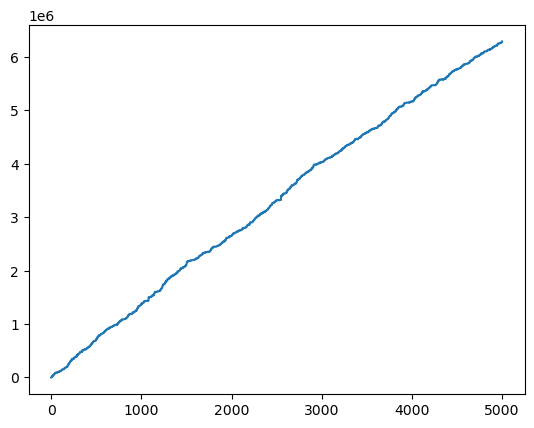

In [52]:
r = run(learner, env, 5000)
print(f'Sharpe Ratio: {round(16 * np.mean(r) / np.std(r), 3)}')
plt.plot(np.cumsum(r))
plt.show()

## 4c Optimal Action
### Sample cross section of action under certain holdings

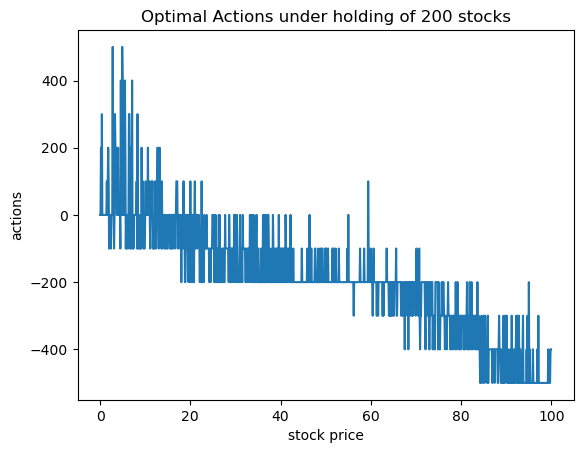

In [53]:
act = []
for i in range(0,21000):
    act.append(learner.greedy_action(stateSpace[i]).shares_traded)
# when holding 200 units of stocks
n = 12
# plotting cross sectional actions
fig,ax = plt.subplots()
ax.plot(np.arange(0,100,0.1),act[1000*n:1000*n+1000])
ax.set_xlabel('stock price')
ax.set_ylabel('actions')
ax.set_title('Optimal Actions under holding of 200 stocks');

In [54]:
x = np.linspace(0.1, 100, 1000)
y = np.linspace(-1000, 1000, 21)

X, Y = np.meshgrid(x, y)
act = []
for i in range(0,21000):
    act.append(learner.greedy_action(stateSpace[i]).shares_traded)
Z = np.array(act).reshape(21,1000)

### Original Data (unsmoothed)
Not much information can be obtained by viewing it in 3D, so plotting the contour diagram below

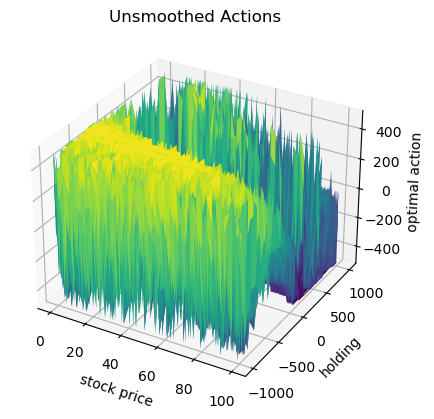

In [55]:
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('stock price')
ax.set_ylabel('holding')
ax.set_zlabel('optimal action')
ax.set_title('Unsmoothed Actions');

### Unsmoothed Contour Plot

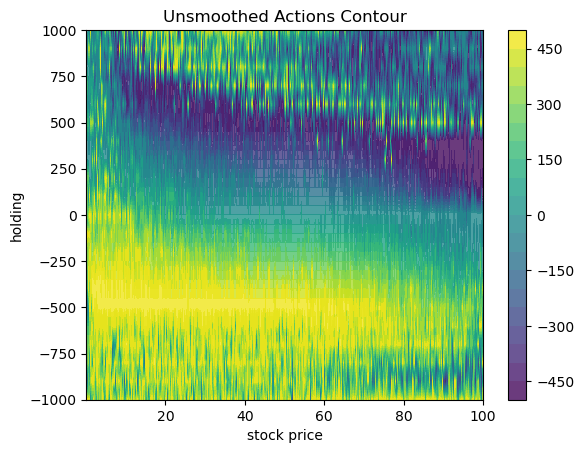

In [56]:
fig,ax = plt.subplots()
contourf_ = ax.contourf(X, Y, Z, 20, alpha = 0.8)
cbar = fig.colorbar(contourf_)
ax.set_xlabel('stock price')
ax.set_ylabel('holding')
ax.set_title('Unsmoothed Actions Contour');

### Smoothed Data (Gaussian Smoothing)

Since the data is rather noisy for the action contour plots, we can smooth out the data and try to see the pattern described in section $ 4d $ more clearlly

In [57]:
from scipy.ndimage.filters import gaussian_filter
sigma = 0.7
data = gaussian_filter(Z, sigma)

/var/folders/2q/8ydy93qj5rg98hm1_12pfmrw0000gn/T/ipykernel_68581/2339014797.py:1: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


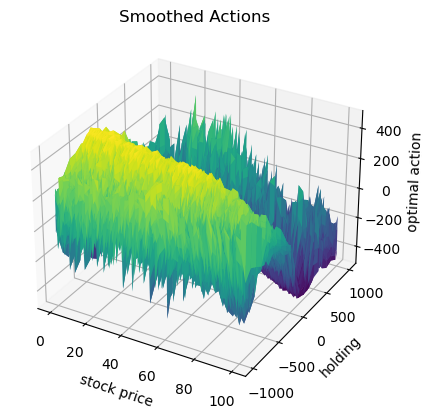

In [58]:
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, data, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('stock price')
ax.set_ylabel('holding')
ax.set_zlabel('optimal action')
ax.set_title('Smoothed Actions');

### Smoothed contour plot

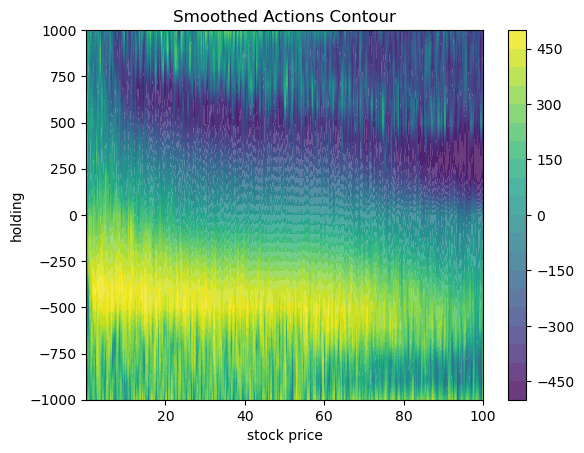

In [59]:
fig,ax = plt.subplots()
contourf_ = ax.contourf(X, Y, data, 20, alpha = 0.8)
cbar = fig.colorbar(contourf_)
ax.set_xlabel('stock price')
ax.set_ylabel('holding')
ax.set_title('Smoothed Actions Contour');

## 4d Interpretation
1. Stockprice

The O-U Process assumes that the stock price follows mean reversion and reverses to $p_e$. Therefore, When stock price is low, the optimal action is to buy more stocks, knowing that they will increase to $p_e$; Similarly, when stock is high, the optimal strategy is to sell the stock for it to decrease to $p_e$

2. Holding

When holding is a short position, the epsilon greedy function would favour buying orders, which can be illustrated by the large amounts of yellow shadow when holding is negative. In the mean time, there's much more selling orders at high holding condition represented by the large amounts of blue shadows when holdings are high. 

3. Discussion & Justification

The buy/sell action is what one would expect given the mean reverting price dynamics. The training result is one of the better policies amongst all training results, achieving a sharpe ratio of 5.647.

### Justification as follows: 

The optimal action would mostly depend on both the holdings and the prices. At $p_e$, the best action is to stay in this position and not to do any buying/selling orders. At higher prices the model would favour selling orders especially at large holdings, while at lower prices the model would favour buying orders especially at lower holdings. 